## 0. Load packages

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD
import numpy as np
import seaborn as sns
import requests
import pyreadr
from matplotlib import pyplot as plt

## 1. Implement a TARNet for predicting Conditional Average Treatment Effects (CATE)

In [7]:
class TarNet(nn.Module):
    def __init__(self, input_dim):
        super(TarNet, self).__init__()
        
        self.input_dim = input_dim 
        
        #Representation phi
        self.phi = nn.Sequential(
            nn.Linear(self.input_dim, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU(),
            nn.Linear(256, 256),
            nn.ELU()
        )
        
        self.treatment = nn.Sequential(
            nn.Linear(self.input_dim, 1),
            nn.Sigmoid()
        )
        
        #Layer of factual and counter factural
        self.y0 = nn.Sequential(
            nn.Linear(256, 64),
            nn.ELU(),
            nn.Linear(64, 1) 
        )
        
        self.y1 = nn.Sequential(
            nn.Linear(256, 64), 
            nn.ELU(),
            nn.Linear(64, 1)
        )
          
    def forward(self, inputs):
        phi = self.phi(inputs)
        
        t_hat = self.treatment(inputs)
        y0_hat = self.y0(phi)
        y1_hat = self.y1(phi)
                
        out = torch.cat((y0_hat, y1_hat, t_hat), 1)
        return out

In [8]:
def lossFunc(y_true, t_true, predictions):
    y = y_true.reshape(-1,1)
    t = t_true.reshape(-1,1)
    
    y0_hat = predictions[:,0].reshape(-1,1)
    y1_hat = predictions[:,1].reshape(-1,1)
    
    loss = torch.sum((1-t)*(y-y0_hat)**2) + torch.sum(t * (y-y1_hat)**2)
    
    return loss

## 2. Implement the IHDP dataset with response surface B as described in Bayesian Nonparametric Modeling for Causal Inference.

In [9]:
def response_surface_B(t, X):
    #Offset matrix
    W = np.ones(X.shape)*0.5

    #Regression vector
    vals = [0, 0.1, 0.2, 0.3, 0.4]
    probabilities = [0.6, 0.1, 0.1, 0.1, 0.1]
    
    np.random.seed(4)
    beta_B = np.random.choice(vals, X.shape[1], p = probabilities)

    mean_y0 = np.exp(np.dot((X+W), beta_B))
    sigma_y0 = 1

    mean_y1 = np.dot(X, beta_B)-15
    sigma_y1 = 1

    y0 = np.random.normal(mean_y0).reshape(-1, 1)
    y1 = np.random.normal(mean_y1).reshape(-1, 1)
    
    y = (1-t)*y0 + t*y1
    
    return y, y0, y1

## 3. Generate 10 random train / valid / and test splits of the IHDP dataset

In [11]:
#Fetch raw data from github
res = requests.get('https://github.com/vdorie/npci/raw/master/examples/ihdp_sim/data/ihdp.RData')
open('input_data.RData', 'wb').write(res.content)
ihdp = pyreadr.read_r('input_data.RData')['ihdp']

In [12]:
def generate_data_sets(ihdp, seed, plot = False):
    ihdpShuffled = ihdp.sample(frac = 1, random_state =  seed)

    X = ihdp.loc[:, ihdp.columns != 'treat'].values

    #Standardize X values
    mu = np.mean(X, axis = 0)
    sd = np.std(X, axis = 0)
    X = ((X-mu)/sd)

    t = ihdp.loc[:, ihdp.columns == 'treat'].values
    y, y0, y1 = response_surface_B(t, X)

    #train / valid / test splits: 
    N, D = X.shape
    Ntrain = int(0.6 * N)
    Nvalid = int(0.8 * N)

    output = dict()
    
    output['X'] = [X[:Ntrain], X[Ntrain:Nvalid], X[Nvalid:]]
    output['y'] = [y[:Ntrain], y[Ntrain:Nvalid], y[Nvalid:]]
    output['t'] = [t[:Ntrain], t[Ntrain:Nvalid], t[Nvalid:]]
    output['y0'] = [y0[:Ntrain], y0[Ntrain:Nvalid], y0[Nvalid:]]
    output['y1'] = [y1[:Ntrain], y1[Ntrain:Nvalid], y1[Nvalid:]]
    
    if plot: 
        #plt.hist(y*t)
        #plt.hist(y*(1-t))
        sns.histplot(y[t==0], label = 'y | t = 0', color = 'blue')
        sns.histplot(y[t==1], label = 'y | t = 1', color = 'green')
        plt.legend()
        print('Average for t=1: {}'.format(np.mean(t*y)))
        print('Average for t=0: {}'.format(np.mean((1-t)*y)))
        print('Average treatment effect: {}'.format(np.mean(t*y)- np.mean((1-t)*y)))
        print('Average effect on treated (CATT): {}'.format(np.mean((y1-y0)*t)))
    
    return output, D

Average for t=1: -5.743027171851527
Average for t=0: 5.636989313532902
Average treatment effect: -11.380016485384429
Average effect on treated (CATT): -9.485074403299825


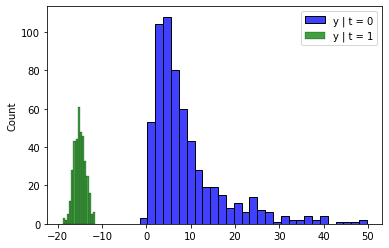

In [15]:
datasets, D = generate_data_sets(ihdp, 42, plot = True)

## 4. Train and tune one model on each of the 10 datasets you have created.


In [16]:
def next_batch(inputs, treatments, outcomes, batchSize):
    # loop over the dataset
    for i in range(0, inputs.shape[0], batchSize):
        # yield a tuple of the current batched data and labels
        yield (torch.from_numpy(inputs[i:i + batchSize].astype(np.float32)), 
               torch.from_numpy(treatments[i:i + batchSize].astype(np.float32)),
               torch.from_numpy(outcomes[i:i + batchSize].astype(np.float32)))

In [17]:
def train_model(model, datasets, EPOCHS = 10, BATCH_SIZE = 64, LR=1e-3, VERBOSE = False):
    Xtrain, Xvalid, Xtest = datasets['X']
    ytrain, yvalid, ytest = datasets['y']
    ttrain, tvalid, ttest = datasets['t']
    
    opt = SGD(model.parameters(), lr=LR)
    model_performance = []

    # loop through the epochs
    for epoch in range(0, EPOCHS):
        # initialize tracker variables and set our model to trainable
        if VERBOSE: print("[INFO] epoch: {}...".format(epoch + 1))
        trainLoss = 0
        valLoss = 0
        samples = 0
        model.train()

        # loop over the current batch of data
        for (batchX, batcht, batchy) in next_batch(Xtrain, ttrain, ytrain, BATCH_SIZE):

            # model, and calculate loss
            predictions = model(batchX)
            loss = lossFunc(batchy, batcht, predictions)

            # zero the gradients accumulated from the previous steps,abs
            # perform backpropagation, and update model parameters
            opt.zero_grad()
            loss.backward()
            opt.step()

            # update training loss, accuracy, and the number of samples visited
            trainLoss += loss.item()
            samples += batchy.size(0)
                
        #Store model and validation error after each epoch: 
        PATH = "model_checkpoints/model_state_epoch_"+str(epoch)+".pt"
        torch.save(model, PATH)
    
        predictions_valid = model(torch.from_numpy(Xvalid.astype(np.float32)))
        valLoss = lossFunc(torch.from_numpy(yvalid.astype(np.float32)),
                           torch.from_numpy(tvalid.astype(np.float32)),
                           predictions_valid).detach().numpy()
        model_performance.append(valLoss / yvalid.shape[0])

        # display model progress on the training and validation data
        trainTemplate = "epoch: {} train loss: {:.3f} val loss {:.3f}"
        if VERBOSE: print(trainTemplate.format(epoch + 1, 
                                               (trainLoss / samples), 
                                               (valLoss / yvalid.shape[0])))
            
    #Load and return model with minimal validation error 
    best_epoch = np.argmin(model_performance)
    print('Best epoch: {} Best val loss: {:.3f}'.format(best_epoch+1, model_performance[best_epoch]))
    best_model_path = "model_checkpoints/model_state_epoch_"+str(best_epoch)+".pt"
    best_model = torch.load(best_model_path)
    best_model.eval()    
    
    return best_model

## 5. Report the mean and standard error of the Root Mean Average Precision in Heterogeneous Effect (described in the above papers) across the 10 held out test sets.

In [18]:
def PEHE(y0_true, y1_true, predictions):
    y0_hat = predictions[:,0].reshape(-1,1)
    y1_hat = predictions[:,1].reshape(-1,1)
    return torch.mean(((y1_true - y0_true)- (y1_hat - y0_hat))**2)

In [19]:
RootPEHE = []
for i in range(10):
    print('Iteration: {}'.format(i+1))
    datasets, D = generate_data_sets(ihdp, 42+i, plot = False)
    
    model = TarNet(D)
    model = train_model(model, 
                        datasets, 
                        EPOCHS = 100, 
                        BATCH_SIZE = 128,
                        LR = 1e-5,
                        VERBOSE = False)

    #Calcualte mean and standard error of the Root Mean Average Precision on test data     
    _, _, Xtest = datasets['X']
    _, _, ytest = datasets['y']
    _, _, ttest = datasets['t']
    _, _, y0test = datasets['y0']
    _, _, y1test = datasets['y1']
    
    predictions_test = model(torch.from_numpy(Xtest.astype(np.float32)))
    
    RootPEHE.append(torch.sqrt(PEHE(torch.from_numpy(y0test.astype(np.float32)), 
                                    torch.from_numpy(y1test.astype(np.float32)), 
                                    predictions_test)).detach().numpy())
    
print('************************')
print('Mean of Root PEHE: {:.3f}'.format(np.nanmean(RootPEHE)))
print('Standard Error of Root PEHE: {:.3f}'.format(np.std(RootPEHE)))

Iteration: 1
Best epoch: 100 Best val loss: 54.070
Iteration: 2
Best epoch: 100 Best val loss: 66.243
Iteration: 3
Best epoch: 74 Best val loss: 50.270
Iteration: 4
Best epoch: 84 Best val loss: 56.477
Iteration: 5
Best epoch: 100 Best val loss: 52.997
Iteration: 6
Best epoch: 88 Best val loss: 52.783
Iteration: 7
Best epoch: 100 Best val loss: 51.086
Iteration: 8
Best epoch: 37 Best val loss: 38.152
Iteration: 9
Best epoch: 67 Best val loss: 70.211
Iteration: 10
Best epoch: 100 Best val loss: 58.835
************************
Mean of Root PEHE: 7.872
Standard Error of Root PEHE: 0.705
